# Siamese neural networks
---

Nathan L. Toner

## Introduction

Siamese networks (problematic name) tell whether two inputs are the same or different. That's it!

Siamese networks comprise two branches that each take an input and encode it into a latent space, followed by some comparison between these two encoded inputs that results in a similarity measure.

![Siamese network example](figures/siamese_structure.png)

[*L. V. Utkin, M. S. Kovalev, and E. M. Kasimov, “An explanation method for Siamese neural networks,” arXiv:1911.07702 [cs, stat], Nov. 2019, Accessed: Aug. 03, 2020.*][1]

The two encoders are *identical*, i.e., it's the same network on the same silicon running on each image.

Given a dataset of pairs of inputs $\mathcal{X} = \big\{(x_i, x_j), y_{ij}\big\}$ such that $y_{ij} = 1$ if $x_i$ and $x_j$ represent the same class and $y_{ij} = 0$ otherwise, we encode each input into a latent space:

$$
\begin{align}
h_i &= A\big(x_i, \theta \big) \\
h_j &= A\big(x_j, \theta \big)
\end{align}
$$

where $A(\cdot, \theta)$ is some model parameterized by $\theta$ operating on its input. We then calculate a distance measure between outputs such as the $l_1$ norm:

$$
d_{ij} = \big\lVert h_i - h_j \big\rVert_1 = \big\lVert A\big(x_i\big) - A\big(x_j\big) \big\rVert_1
$$

Finally, we define a loss function that penalizes large distance measures for similar objects (i.e., $y_{ij} = 1$), and small distance measures for dissimilar objects (i.e., $y_{ij} = 0$). Typically the "contrastive loss" function or some variation thereof is used.

$$
L(y, d) = y_{ij} d_{ij}^2 + (1 - y_{ij}) \max \big((m - d_{ij})^2, 0\big)
$$

Contrastive loss tries to push our distance measure $d \rightarrow 0$ for similar pairs of objects, and to some margin $d \rightarrow m$ (typically chosen as $m = 1$) for dissimilar objects.

And that's it! You can plug whatever algorithm you want in for $A$ as long as you can train it iteratively using something like backpropagation and the chosen loss function. The resulting network will tell you whether two inputs are similar or dissimilar, and give you an idea of *how* similar they are.

## Cool...but why?

With a typical classifier, you need examples of all classes you plan to identify when training, and you need these examples to be balanced. Many real-world problems include *unknown* classes that you do not have at training time. This is a part of the "open set" classification problem and is illustrated below.

![Open set example](figures/open_set.png)

[*C. Geng, S. Huang, and S. Chen, “Recent Advances in Open Set Recognition: A Survey,” arXiv:1811.08581 [cs, stat], Jul. 2019, Accessed: Jan. 07, 2020.*][2]


It turns out a network trained like this works surprisingly well on never-before-seen classes drawn from a similar domain. We're going to work through an example of this with hand-written numbers.

Furthermore, neural networks are typically very data hungry. You need *a lot* of data to train them. Siamese networks alleviate this problem by training on pairs, giving you a combinatorial explosion of examples. Given a training dataset of $n$ examples, a Siamese network trains on $n$ choose 2 (sort of, you have to drop some to balance things typically). This is illustrated below.

![Data pair illustration](figures/pair_illustration.png)

Finally, you can get clever about how you define same and different and the examples you give of each in your dataset to develop a network that is far more robust to *semantic* noise than otherwise possible. For example, we will be looking at identifying whether two digits are the same or different, but if we have a dataset representing digits drawn by several different people, we could attempt to identify whether *any* two digits have the same author!

There are actually some interesting papers on forgery detection using exactly this approach.

[1]: http://arxiv.org/abs/1911.07702
[2]: http://arxiv.org/abs/1811.08581

## Set up the environment
---

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Flatten, BatchNormalization, Input,
                                     Conv2D, GlobalAveragePooling2D, LeakyReLU,
                                     Subtract)
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

Define helper functions.

In [2]:
def l1_norm(inputs):
    """Takes the norm of two input vectors.
    
    Args:
        inputs: list of two feature fectors (Tensors).
        
    Returns:
        l1 norm between the two input vectors.
        
    """
    u, v = inputs
    difference = tf.abs(u - v)
    return tf.reduce_mean(difference, axis=[-1])

In [3]:
def contrastive_loss(y, d):
    """Contrastive loss function for training Siamese net.
    
    Args:
        y: list of true labels for a batch.
        d: list of distance measures for batch from net.
        
    Returns:
        Contrastive loss between y and d.
        
    """
    margin = 1.
    y = tf.cast(y, dtype=tf.float32)
    return tf.reduce_mean(y * tf.square(d) + (1. - y) * tf.square(tf.maximum(margin - d, 0.)))

In [4]:
def create_pairs(x, digit_indices, digits):
    """Positive and negative pair creation.
    
    Alternates between positive and negative pairs.
    
    Args:
        x: data for which we are creating pairs.
        digit_indices: list of lists of indices for each number.
        digits: list of digits to include in pairs.
        
    Returns:
        pairs: list of image pairs.
        labels: list of associated lables: 1 for same, 0 for different.
    
    """
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in digits]) - 1
    for d, idx in zip(digits, range(len(digits))):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randint(1, len(digits) - 1)
            dn = digits[(idx + inc) % len(digits)]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [5]:
def compute_accuracy(labels, predictions):
    """Compute classification accuracy with a fixed threshold on distances.
    
    Args:
        labels: list of true labels for the batch.
        predictions: list of distance measures for batch from net.
        
    Returns:
        Prediction accuracy.
        
    """
    pred = tf.cast(predictions < 0.5, dtype=tf.float32)
    labels = tf.cast(labels, dtype=tf.float32)
    return tf.reduce_mean(tf.metrics.binary_accuracy(labels, pred))

In [6]:
def plot_pairs(data, labels, num_pairs=10):
    """Plots MNIST data pairs.
    
    Args:
        data: list of image pairs from which to draw images.
        labels: list of labels (same/different) for data.
        
    Keyword Args:
        num_pairs: number of pairs to draw. Default is 10.
        
    """
    fig, axes = plt.subplots(2, num_pairs,
                             figsize=(2*num_pairs, 3))
    for i in range(num_pairs):
        im = random.randint(0, len(data))
        ax = axes[0, i]
        ax.imshow(data[im][0, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax = axes[1, i]
        ax.imshow(data[im][1, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('same' if labels[im] == 1 else 'different',
                      rotation=0, labelpad=25)
    axes[0, 0].set_title('Training pairs')
    plt.tight_layout(w_pad=-60)
    plt.show()

In [7]:
def process_data(x):
    """Preprocess the MNIST data.
    
    Args:
        x: raw MNIST data.
        
    Return:
        MNIST data converted to float, expanded for TF convolutions,
            and scaled to the range [0, 1].
        
    """
    data = x.astype('float32')
    data = np.expand_dims(data, axis=-1)
    data /= 255
    return data

In [8]:
def test_network(model, data, labels, thresh=0.5):
    """Utility for testing the network on some data.
    
    Args:
        model: the trained model.
        data: pairs of images from which to draw test samples.
        labels: true labels (same/different) of data.
        
    Keyword Args:
        thresh: decision threshold for classifier. Default is 0.5.
        
    """
    idx = random.randint(0, len(data)-1)
    if labels[idx] == 1:
        label = 'same'
    else:
        label = 'different'
    image_a, image_b = data[idx]
    image_a = np.expand_dims(image_a, axis=0)
    image_b = np.expand_dims(image_b, axis=0)
    result = model.predict([image_a, image_b])

    # Plot the images.
    fig, axes = plt.subplots(1, 2,
                             figsize=(6, 3))
    for i in range(2):
        ax = axes[i]
        ax.imshow(data[idx, i, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    # Print the results of the network.
    print(f'Distance output: {result}')
    if result < thresh:
        pred = 'same'
    else:
        pred = 'different'
    print(f'True label: {label}')
    print(f'Predicted label: {pred}')

In [9]:
def plot_mnist(data, labels, num_row=2, num_col=5):
    fig, axes = plt.subplots(num_row, num_col,
                             figsize=(1.5*num_col, 2*num_row))
    for i in range(num_row * num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(data[i, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

In [10]:
def plot_roc_curve(fpr, tpr, auc):
    """Utility for plotting a ROC curve.
    
    Args:
        fpr: list of false positive rates.
        tpr: list of true positive rates.
        auc: area under the curve.
    
    """
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.5f}')
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.legend()
    plt.show()

## Import data and create data pairs
---

We are going to use the [MNIST dataset][1] for our experiment. MNIST comprises 28x28 pixel black and white images of handwritten digits between 0 and 9.

We will first import the images into our environment. We then select which numbers are seen during training and which are seen during testing. We can choose any or all of the numbers for both, but to illustrate the generalization capabilities of Siamese nets, we will test on numbers that we never see in training.

We then create training and testing *pairs* by selecting two images of the same number and assigning a label of 1 (same class), and selecting two images of different numbers and assigning a label of 0 (different class). We generate pairs using every number in the dataset, and these pairs and their labels go into large training and testing datasets. This is illustrated below.

![Data pair illustration](figures/pair_illustration.png)

First we load and preprocess the data.

[1]: http://yann.lecun.com/exdb/mnist/

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = process_data(X_train)
X_test = process_data(X_test)
in_dim = X_train.shape[-3:]

Plot some of the image pool.

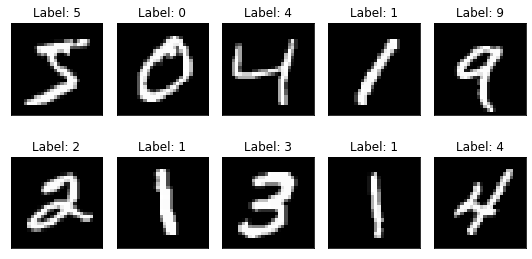

In [12]:
plot_mnist(X_train, y_train)

Create training and testing positive and negative pairs.

Here we select which numbers are seen during training vs. which are seen during testing. We can have as much or as little overlap as we want, so for instance training and testing could use all available digits, or we could divide digits up so only even numbers are seen in training and odd numbers seen in testing. The latter case allows us to see how well the network generalizes to never-before-seen classes drawn from the same domain (handwritten digits).

In [13]:
digit_indices = np.array([np.where(y_train == i)[0] for i in range(10)])
digits = [0, 1, 3, 5, 7, 9]  # odd numbers (and zero) only in training
tr_pairs, tr_y = create_pairs(X_train, digit_indices, digits)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
digits = [2, 4, 6, 8]  # even numbers only in testing
te_pairs, te_y = create_pairs(X_test, digit_indices, digits)

Plot some examples of pairs.

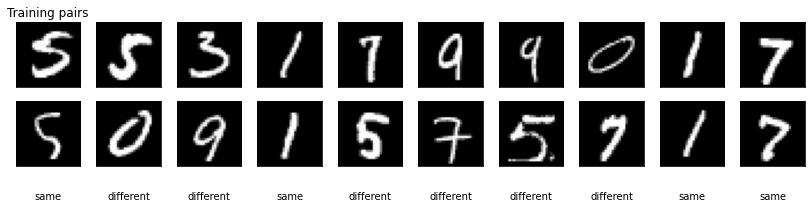

In [14]:
plot_pairs(tr_pairs, tr_y)

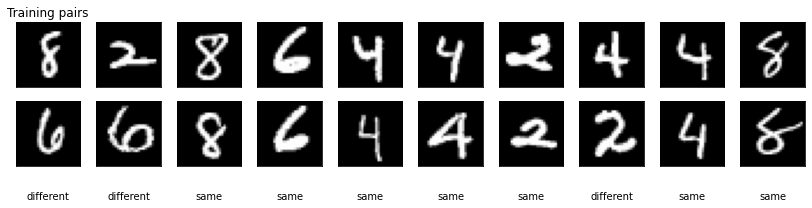

In [15]:
plot_pairs(te_pairs, te_y)

## Train the network
---

First we define the base network. Remember, *this can be **anything** we can train!*

We will make a convolutional neural network with three layers and skip connections. Each layer uses batch normalization, convolution, and then a leaky-ReLU activation before the result of the activation is added back to the layer's input.

![Convolutional network structure](figures/conv_net.png)

Finally there is a fully connected layer with sigmoid activation that gives us a flat feature vector on which we can take our distance measure.

In [16]:
num_filters = 8

def create_base_net(input_dim):
    x_in = Input(shape=input_dim)
    
    # First block.
    x = BatchNormalization()(x_in)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(x)
    h_1 = x + x_in
    
    # Second block.
    x = BatchNormalization()(h_1)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(x)
    h_2 = x + h_1
    
    # Third block.
    x = BatchNormalization()(h_2)
    x = LeakyReLU()(x)
    x = Conv2D(1, kernel_size=(3, 3), padding='same')(x)
    h_3 = x + Conv2D(1, kernel_size=(1, 1), padding='same')(h_2)
    
    # Output block.
    x = Flatten()(h_3)
    x = Dense(20)(x)
    out = tf.math.sigmoid(x)
    return Model(inputs=x_in, outputs=out, name='base_model')

In [17]:
base_model = create_base_net(in_dim)
base_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 1)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 8)    80          leaky_re_lu[0][0]                
_________________________________________________________________________________________

Next we create put together the overarching network architecture. We want to pass two different inputs through the same base network, and feed both outputs into our distance measure.

![Siamese network architecture](figures/siamse_net.png)

We already created our base network, so now we create inputs for each side of the Siamese network. These are basically just placeholders so TensorFlow knows where our inputs go later.

In [18]:
input_a = Input(shape=in_dim, name='input_a')
input_b = Input(shape=in_dim, name='input_b')

We pass each input through the *same* base model.

In [19]:
output_a = base_model(input_a)
output_b = base_model(input_b)

Finally we calculate a distance measure between the encoded inputs.

In [20]:
distance = l1_norm([output_a, output_b])

Compile the model so that it accepts two inputs and returns the distance measure between them.

In [21]:
model = Model(inputs=[input_a, input_b],
              outputs=distance,
              name='siamese_model')
model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
base_model (Model)              (None, 20)           16514       input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 20)]         0           base_model[1][0]     

Before we train, we have to tell TensorFlow/Keras what optimizer we are using, what loss function we are minimizing (or maximizing), and what if any metrics we want to report back.

Here we use the [Adam optimizer][1] (an adaptive momentum-based gradient descent optimizer), and the contrastive loss function described in the introduction.

[1]: https://ruder.io/optimizing-gradient-descent/index.html#adam

In [22]:
model.compile(loss=contrastive_loss,
              optimizer='adam',
              metrics=[compute_accuracy])

Finally we train the model on our data and test.

In [23]:
model.fit(x=[tr_pairs[:, 0], tr_pairs[:, 1]],
          y=tr_y,
          batch_size=128,
          epochs=20,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 65040 samples, validate on 7656 samples
Epoch 1/20
65040/65040 [==============================] - 39s 602us/sample - loss: 0.1365 - compute_accuracy: 0.8157 - val_loss: 0.1927 - val_compute_accuracy: 0.6967
Epoch 2/20
65040/65040 [==============================] - 41s 634us/sample - loss: 0.1181 - compute_accuracy: 0.8424 - val_loss: 0.1888 - val_compute_accuracy: 0.7035
Epoch 3/20
65040/65040 [==============================] - 41s 638us/sample - loss: 0.1133 - compute_accuracy: 0.8459 - val_loss: 0.1828 - val_compute_accuracy: 0.7177
Epoch 4/20
65040/65040 [==============================] - 41s 626us/sample - loss: 0.1108 - compute_accuracy: 0.8483 - val_loss: 0.1755 - val_compute_accuracy: 0.7321
Epoch 5/20
65040/65040 [==============================] - 41s 623us/sample - loss: 0.1091 - compute_accuracy: 0.8522 - val_loss: 0.1735 - val_compute_accuracy: 0.7404
Epoch 6/20
65040/65040 [==============================] - 41s 638us/sample - loss: 0.1080 - compute_accuracy: 0.8529

Save/load the model.

In [32]:
model.save('model/siamese_net.h5')

In [25]:
model = load_model('model/siamese_net.h5',
                   custom_objects={
                       'contrastive_loss': contrastive_loss,
                       'compute_accuracy': compute_accuracy})

## Demonstration of the trained model
---

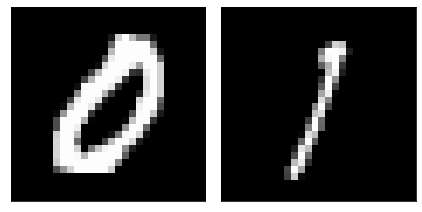

Distance output: [0.69892234]
True label: different
Predicted label: different


In [33]:
test_network(model, tr_pairs, tr_y)

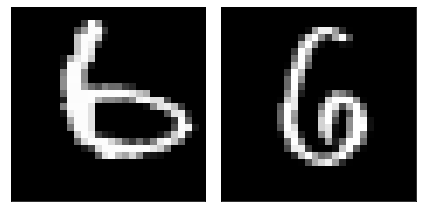

Distance output: [0.34478763]
True label: same
Predicted label: same


In [34]:
test_network(model, te_pairs, te_y)

## Analyze the trained model
---

This is a binary classifier, so any analysis methods that are valid for binary classifiers can be used to investigate the performance of our model. For instance, it is often useful to look at the confusion matrix, receiver operating characteristic (ROC) curve, and precision-recall curve.

Here I show a ROC curve for the model.

In [35]:
predictions = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

In [36]:
fpr, tpr, thresholds = roc_curve(te_y, 1 - predictions)

In [37]:
auc = roc_auc_score(te_y, 1 - predictions)

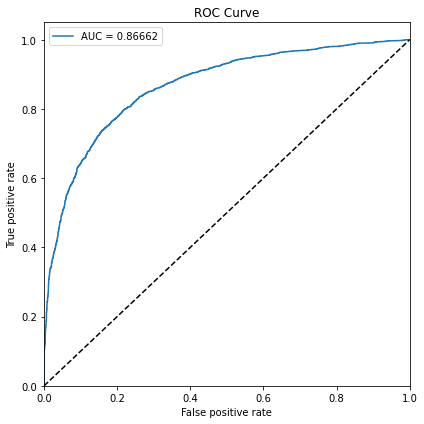

In [38]:
plot_roc_curve(fpr, tpr, auc)